In [1]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: TimeoutError timed out


In [2]:
# b = phoebe.load("../estimations/bundle-saves/ebai-estimates-trimmed")
b = phoebe.load("../estimations/bundle-saves/comp-LID3/ebai-estimates-trimmed")

Wed, 20 Sep 2023 13:44 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:43<00:00,  6.34it/s]


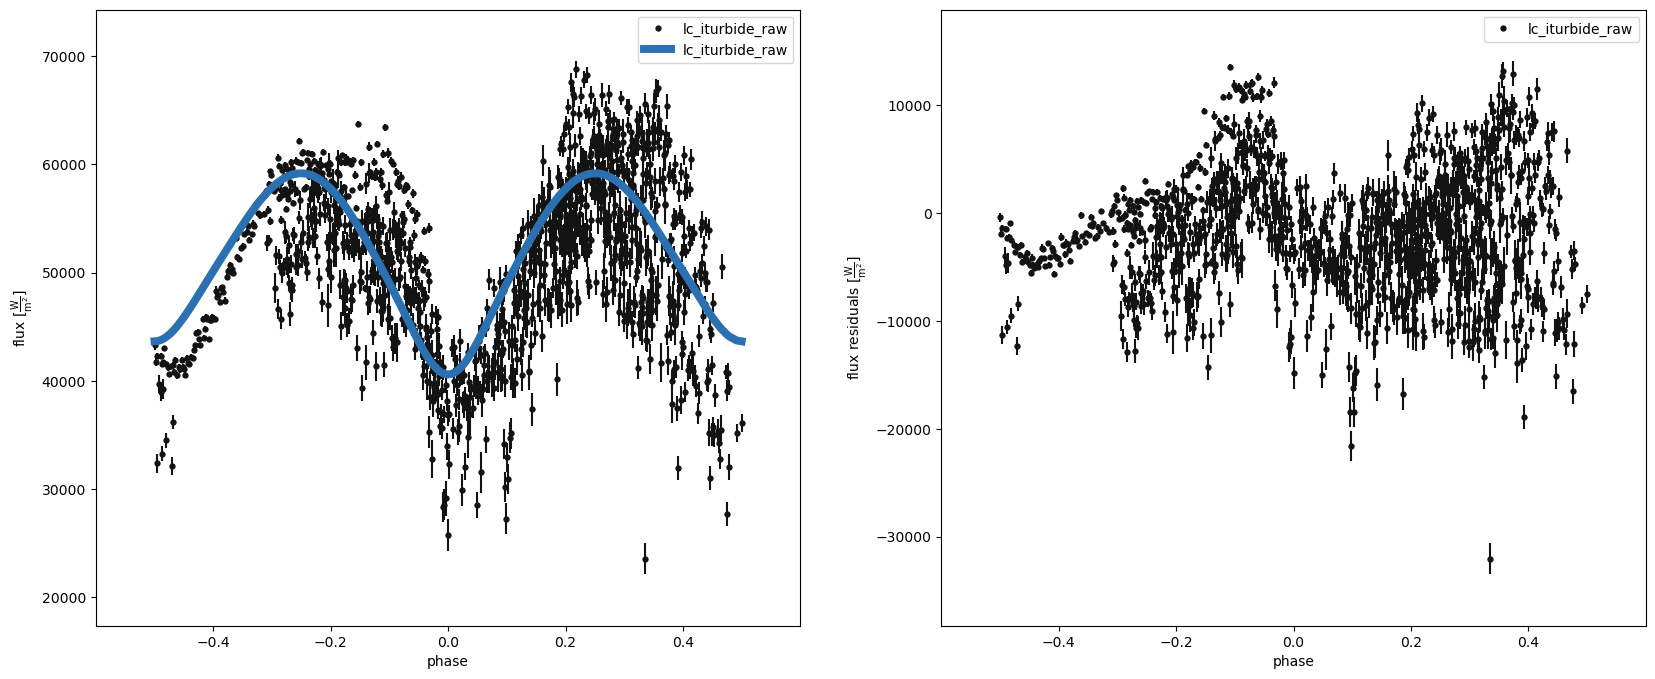

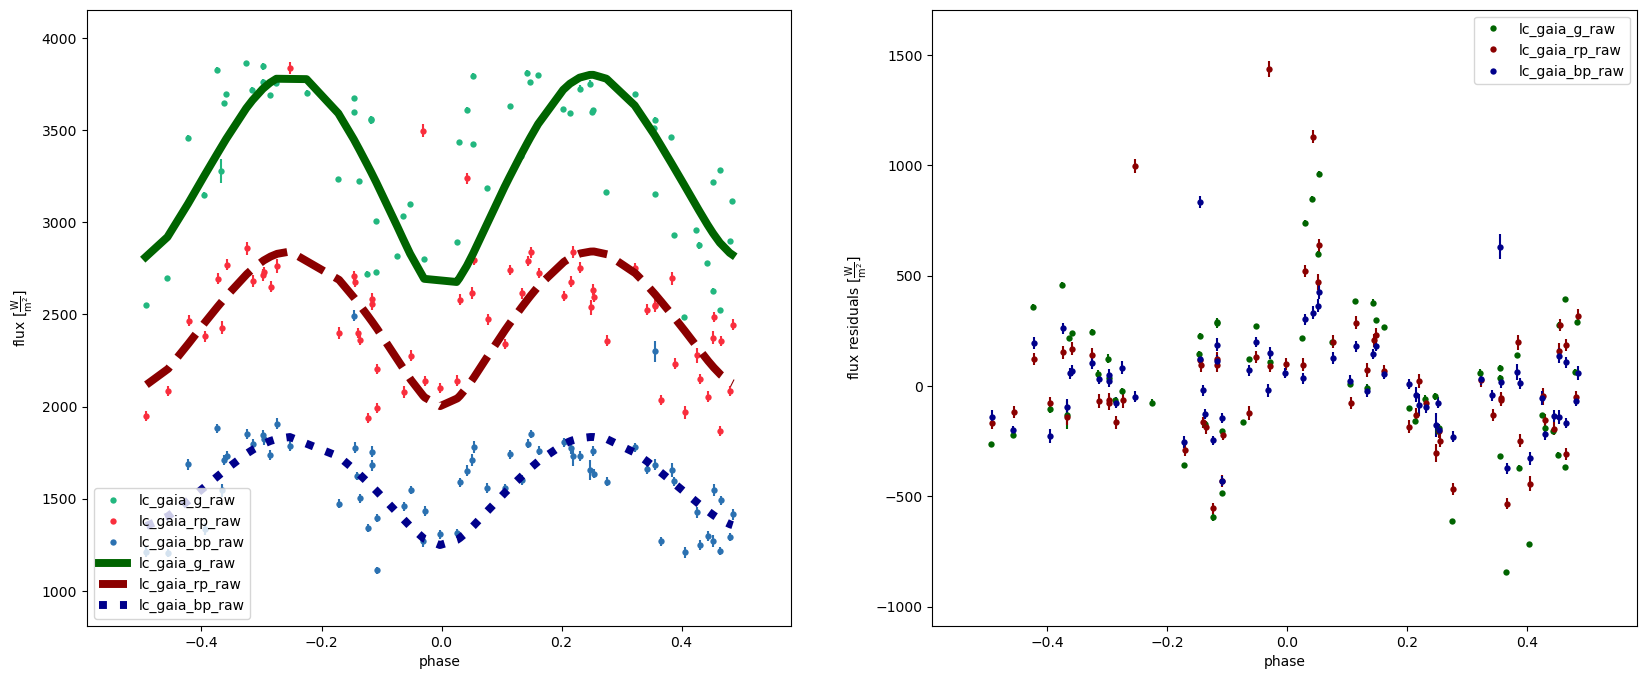

In [3]:
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
allRawDatasets = rawGaiaDatasets + ['lc_iturbide_raw']

gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model='before_optimizers')

gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model='before_optimizers', legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [4]:
def printChi2(b: phoebe.Bundle, model: str):
	print(model, "-------------------------------------", sep='\n')
	print('\t', "Iturbide -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_raw')))
	print('\t', "Gaia -", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	for gd in rawGaiaDatasets:
		print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))

In [5]:
printChi2(b, 'before_optimizers')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974


## Period and `t0_supconj`

In [8]:
opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], label='period_t0', export=True, datasets=allRawDatasets, subfolder="differential-norm-estimates", maxiter=150)
# opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], 'period_t0', False, allRawDatasets, maxiter=100)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_period_t0.py ./results/opt_period_t0_solution


('opt_period_t0', 'opt_period_t0_solution')

Adopted:
t0_supconj@binary@orbit@component = 0.15270 d
period@binary@orbit@component = 0.33358 d

Original values:
  t0_supconj@binary@orbit@component 0.14900860708333175 d
  period@binary@orbit@component 0.3335826898128127 d


Wed, 20 Sep 2023 13:50 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1398/1398 [03:41<00:00,  6.32it/s]


opt_period_t0_solution opt_period_t0_model


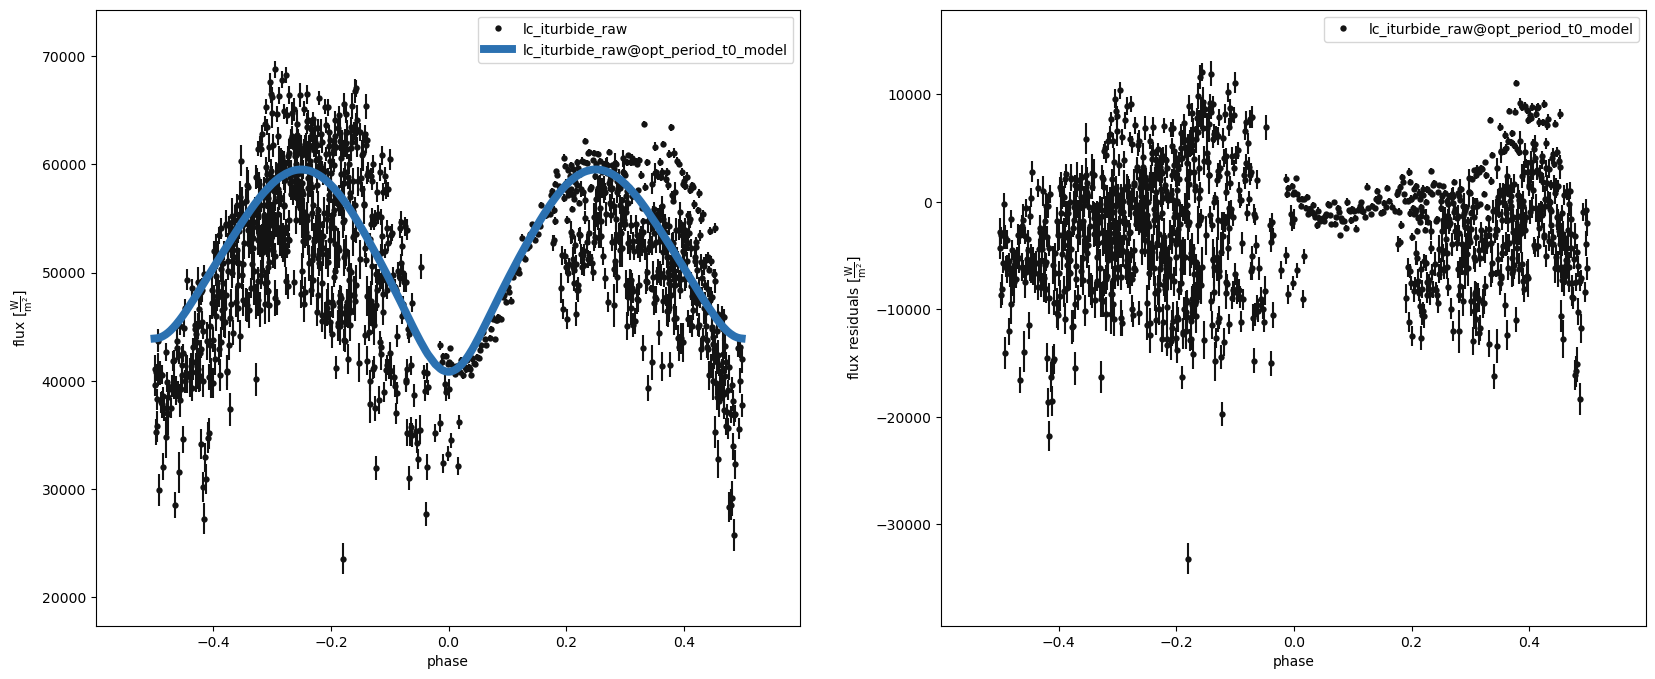

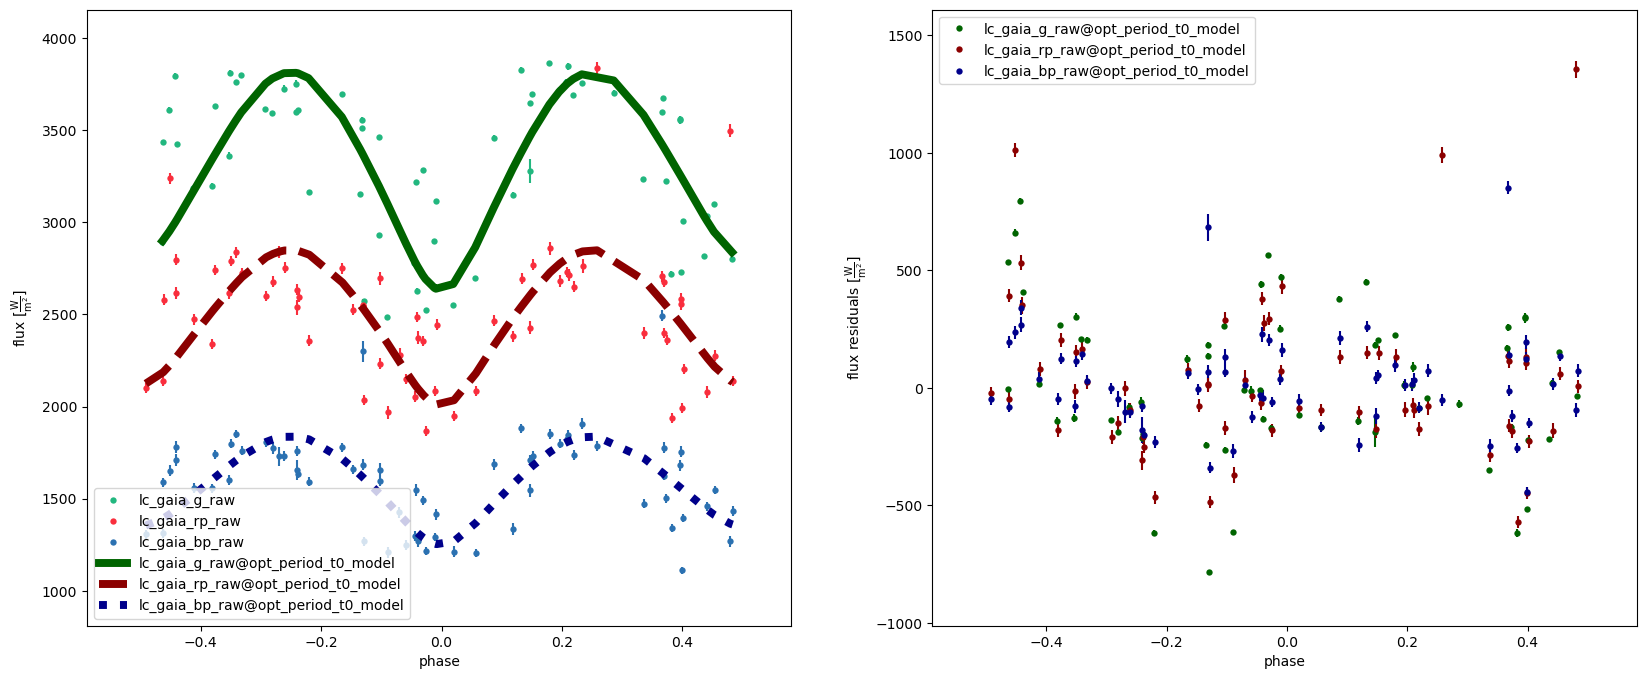

In [6]:
# solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
#                                                           solution_file="./external-jobs/results/opt_period_t0_solution", plot=False, 
#                                                           dataset=allRawDatasets)
# solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, plot=False, dataset=allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
                                                          solution_file="./external-jobs/differential-norm-estimates/results/opt_period_t0_solution", plot=False, 
                                                          dataset=allRawDatasets)
print(solutionName, computeModelName)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [8]:
printChi2(b, 'before_optimizers')
printChi2(b, computeModelName)

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013


### Using Gaia datasets only

Seems like `t0_supconj` might not have been adjusted properly from Iturbide LC

In [17]:
opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], 'period_t0_gaia', True, rawGaiaDatasets, maxiter=200)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_period_t0_gaia.py ./results/opt_period_t0_gaia_solution


('opt_period_t0_gaia', 'opt_period_t0_gaia_solution')

t0_supconj@binary@orbit@component = 0.09631 d
period@binary@orbit@component = 0.33330 d
Adopted
  t0_supconj@binary@orbit@component 0.09152173700368677 d
  period@binary@orbit@component 0.33330212084741745 d


100%|██████████| 1398/1398 [03:38<00:00,  6.40it/s]


opt_period_t0_gaia_solution opt_period_t0_gaia_model


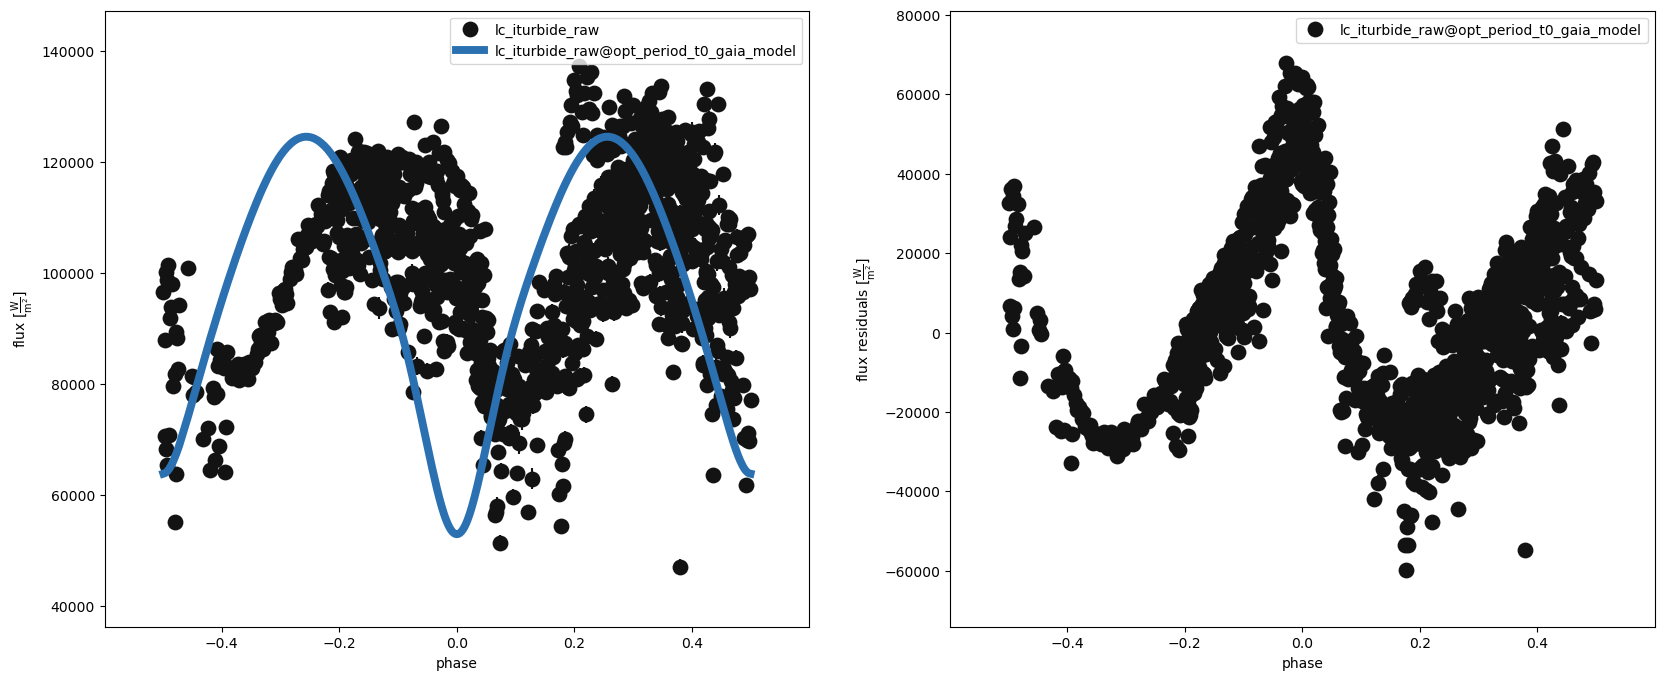

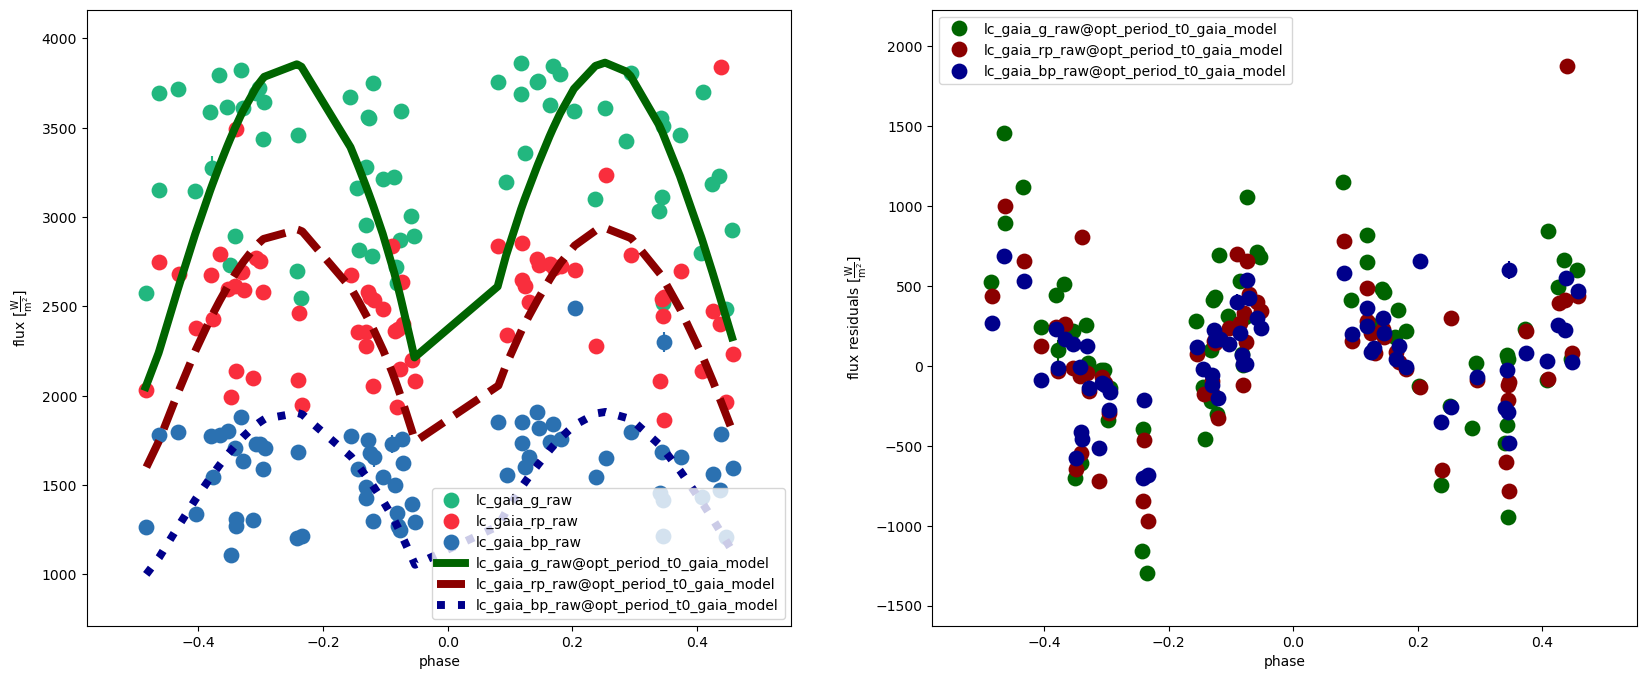

In [9]:
solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, 
                                                          solution_file="./external-jobs/results/opt_period_t0_gaia_solution", plot=False, 
                                                          dataset=allRawDatasets)
print(solutionName, computeModelName)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [27]:
print(b['opt_period_t0_gaia_solution'])

ParameterSet: 11 parameters
R  fitted_twigs@opt_period_t0_...: ['t0_supconj@binary@orbit@component' 'period@binary@orbit@component']
   adopt_parameters@opt_period...: ['t0_supconj@binary@orbit@component', 'period@binary@orbit@component']
   adopt_distributions@opt_per...: False
   adopt_values@opt_period_t0_...: True
R  message@opt_period_t0_gaia@...: Optimization terminated successfully.
R  niter@opt_period_t0_gaia@op...: 63
R  success@opt_period_t0_gaia@...: True
R  initial_values@opt_period_t...: [0.09152173700368677 0.33330212084741745]
R  fitted_values@opt_period_t0...: [0.09631321261339112 0.33329601845912604]
R  fitted_units@opt_period_t0_...: ['d' 'd']
   comments@opt_period_t0_gaia...: 


In [10]:
for m in b.models:
	printChi2(b, m)

before_optimizers
-------------------------------------
	 Iturbide - 1244789.9869257982
	 Gaia - 584040.2179725979
		 lc_gaia_g_raw - 510548.2300158256
		 lc_gaia_rp_raw - 44392.188906850104
		 lc_gaia_bp_raw - 29099.79904992223
opt_period_t0_model
-------------------------------------
	 Iturbide - 497243.39609177766
	 Gaia - 242222.2329210236
		 lc_gaia_g_raw - 208749.42571898212
		 lc_gaia_rp_raw - 20702.319609771515
		 lc_gaia_bp_raw - 12770.487592269945
opt_period_t0_gaia_model
-------------------------------------
	 Iturbide - 2317608.873023375
	 Gaia - 196326.47508051147
		 lc_gaia_g_raw - 169670.57299622413
		 lc_gaia_rp_raw - 16363.08685704666
		 lc_gaia_bp_raw - 10292.815227240679


#### Gaia individual datasets only (`t0_supconj` only)

In [11]:
for gd in rawGaiaDatasets:
	datasetLabel = gd.replace("lc_", "").replace("_raw", "")
	opt_utils.optimize_params(b, ['t0_supconj'], f't0_{datasetLabel}', False, [gd], maxiter=200)

 10%|█         | 20/200 [07:07<1:04:05, 21.36s/it]


In [12]:
gen_utils.saveBundle(b, "individual-gaia-estimates", "ebai-optimizers")

'bundle-saves/ebai-optimizers/individual-gaia-estimates'

t0_gaia_g
-----------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = 0.09610 d

Original values:
  t0_supconj@binary@orbit@component 0.09809062977464766 d


100%|██████████| 1414/1414 [03:40<00:00,  6.42it/s]


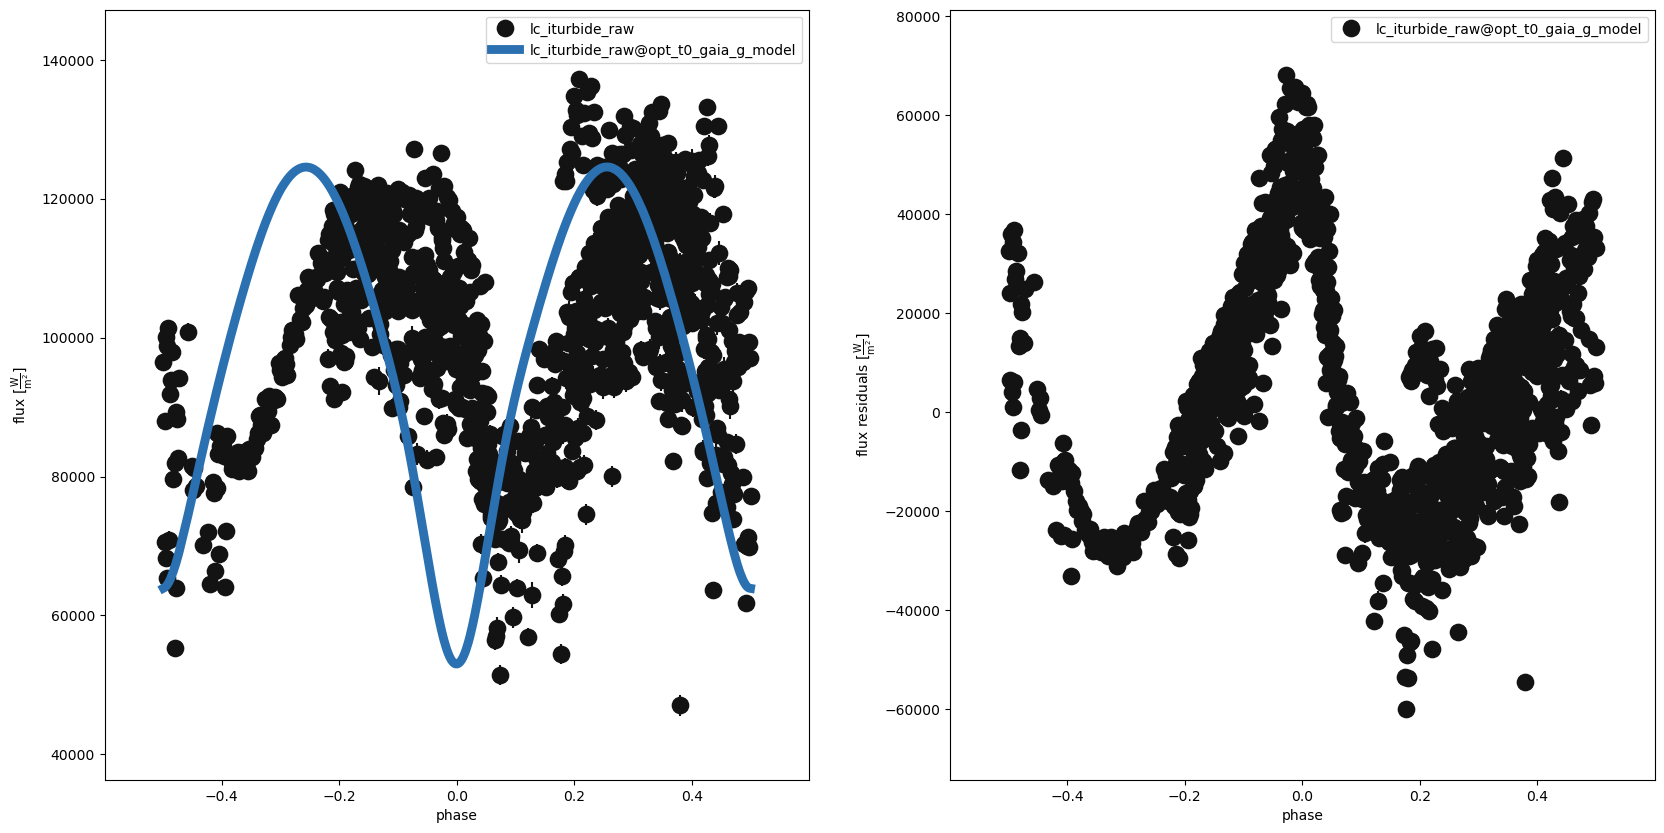

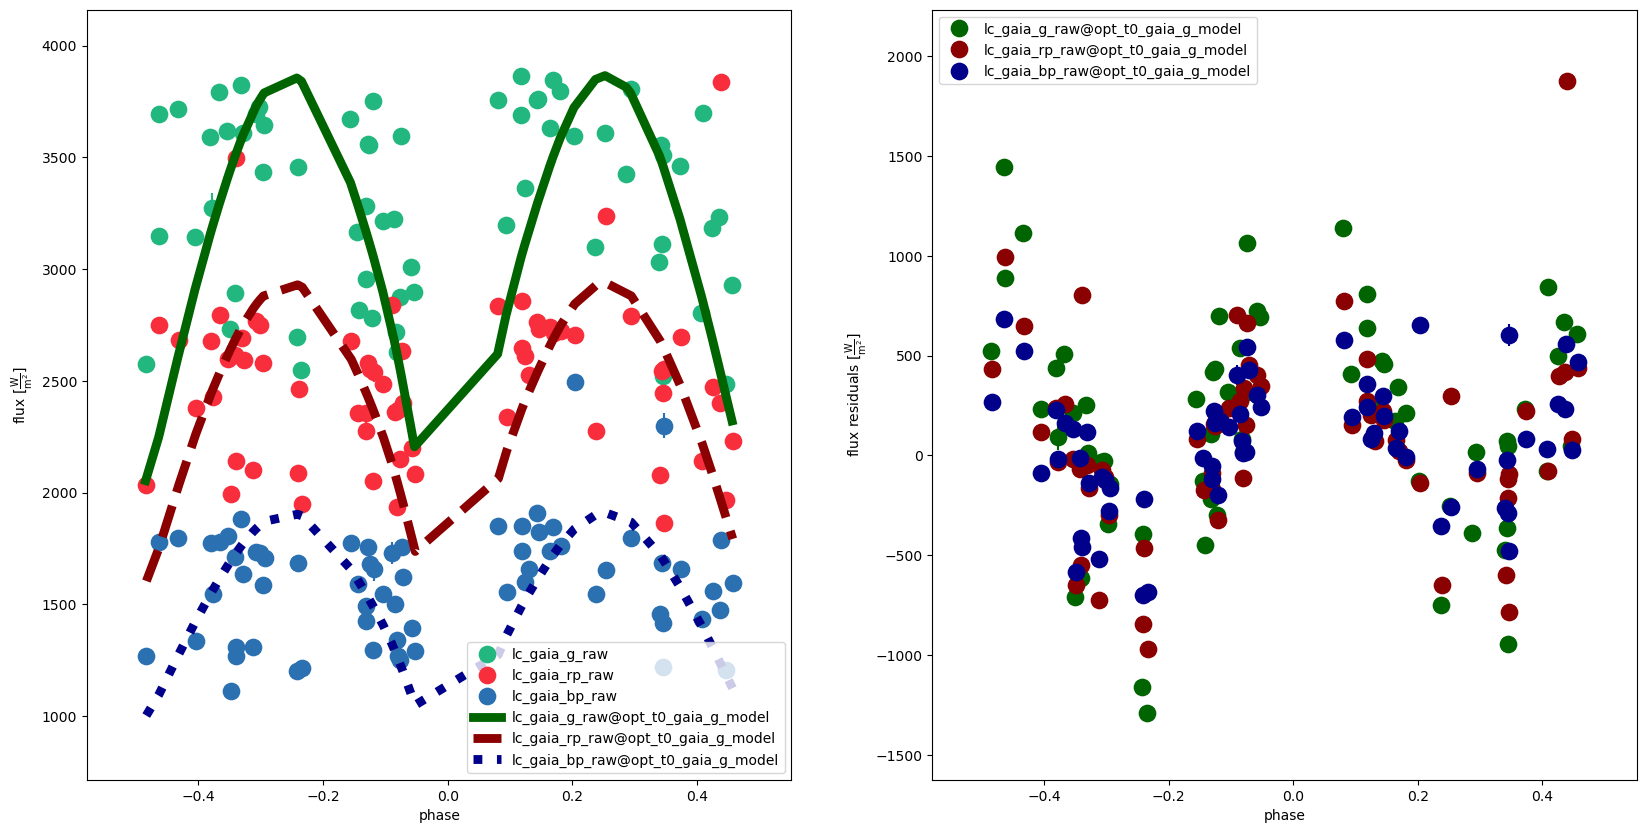


t0_gaia_rp
-----------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = 0.09809 d

Original values:
  t0_supconj@binary@orbit@component 0.09631321261339112 d


100%|██████████| 1414/1414 [03:36<00:00,  6.53it/s]


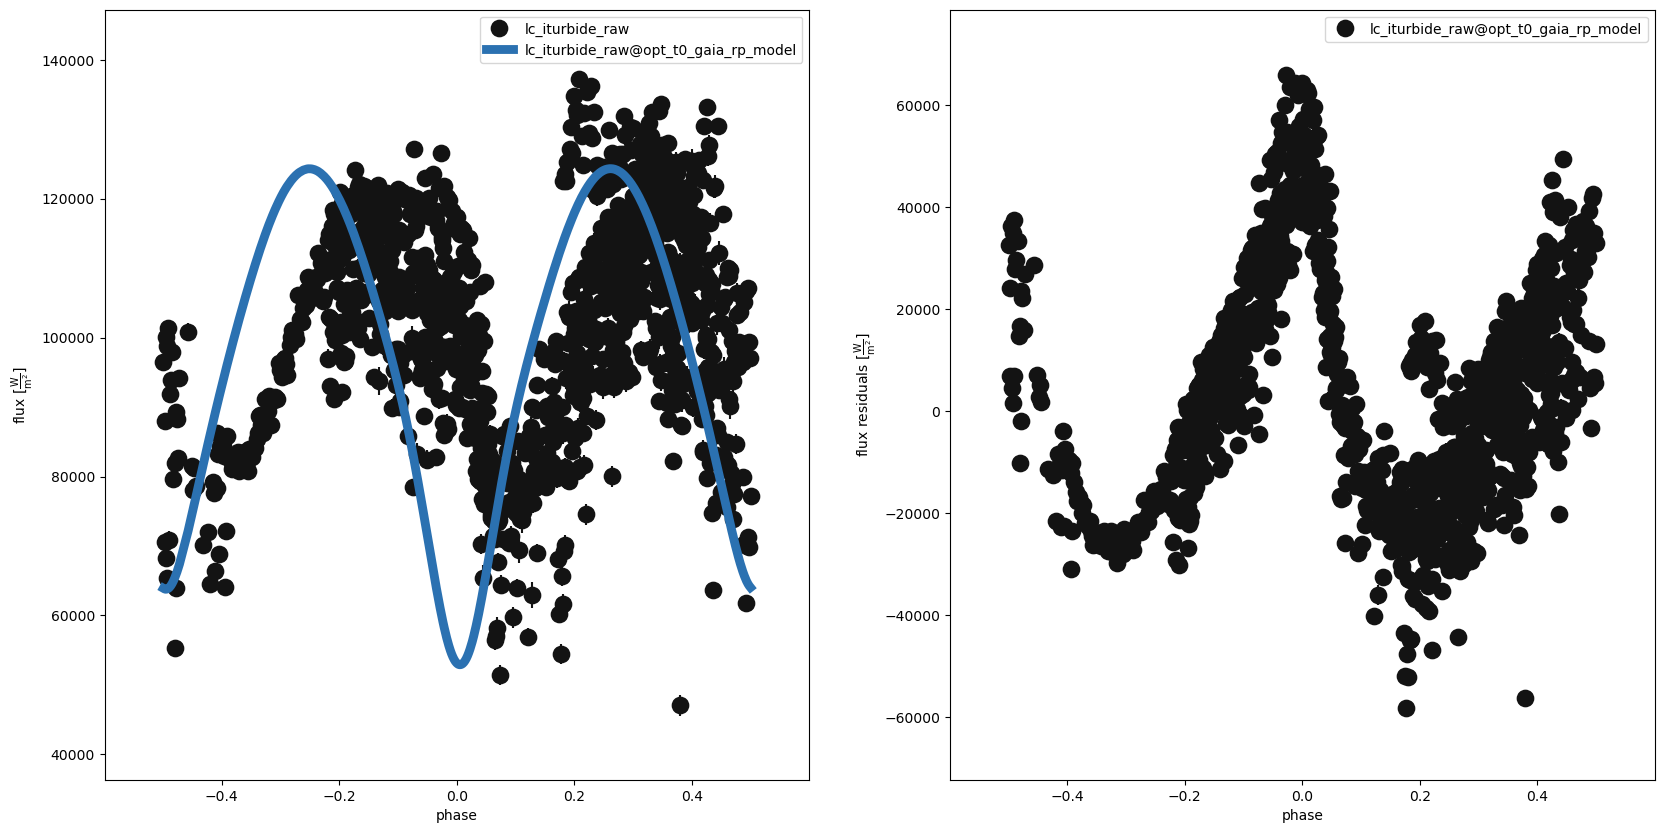

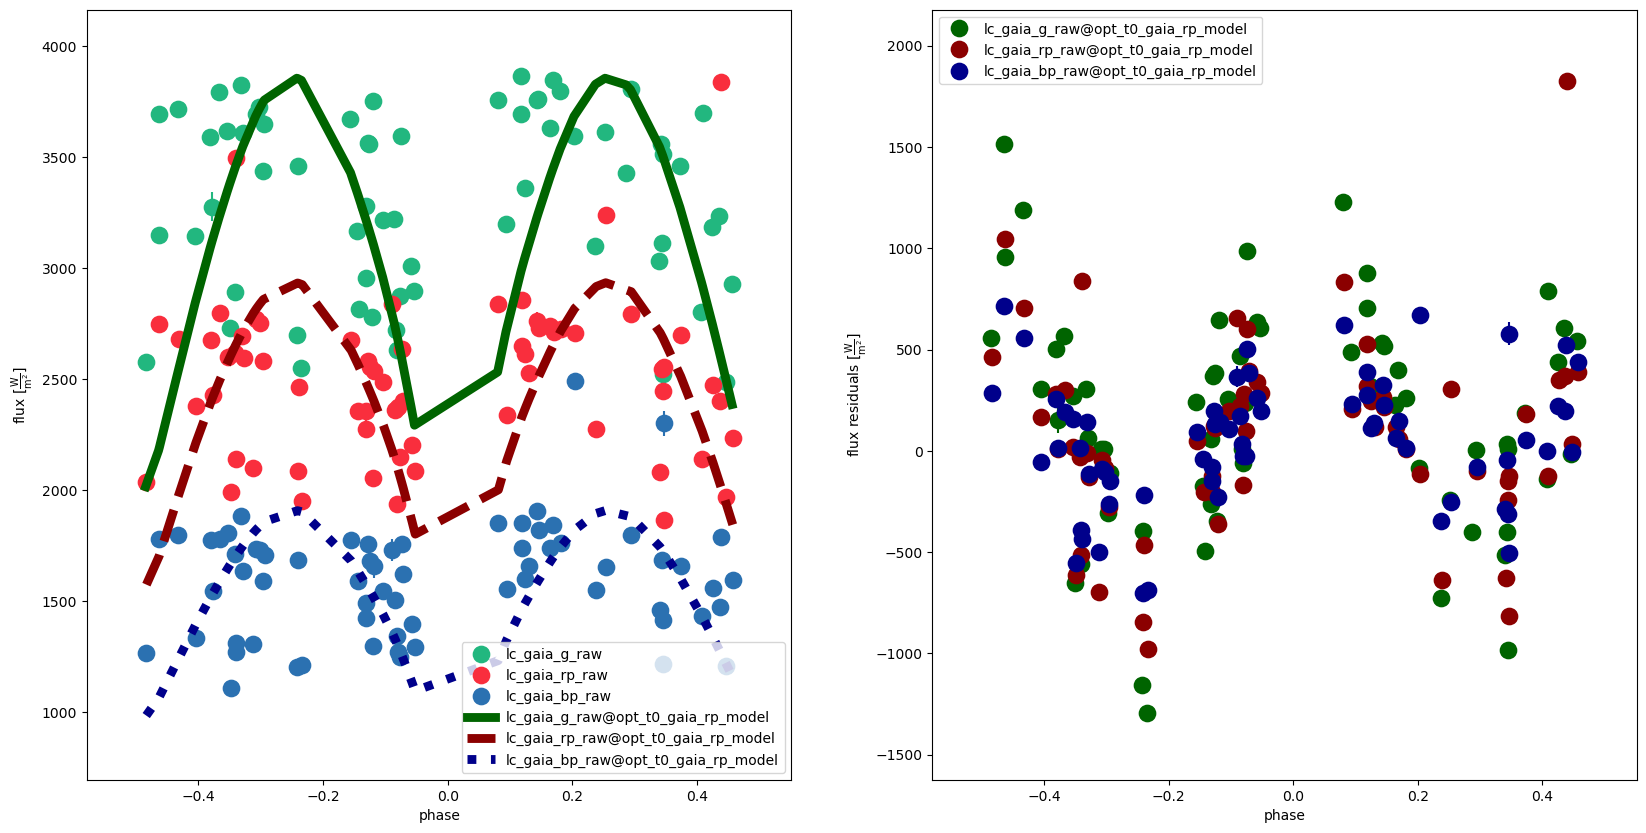


t0_gaia_bp
-----------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = 0.09808 d

Original values:
  t0_supconj@binary@orbit@component 0.09631321261339112 d


100%|██████████| 1414/1414 [03:31<00:00,  6.69it/s]


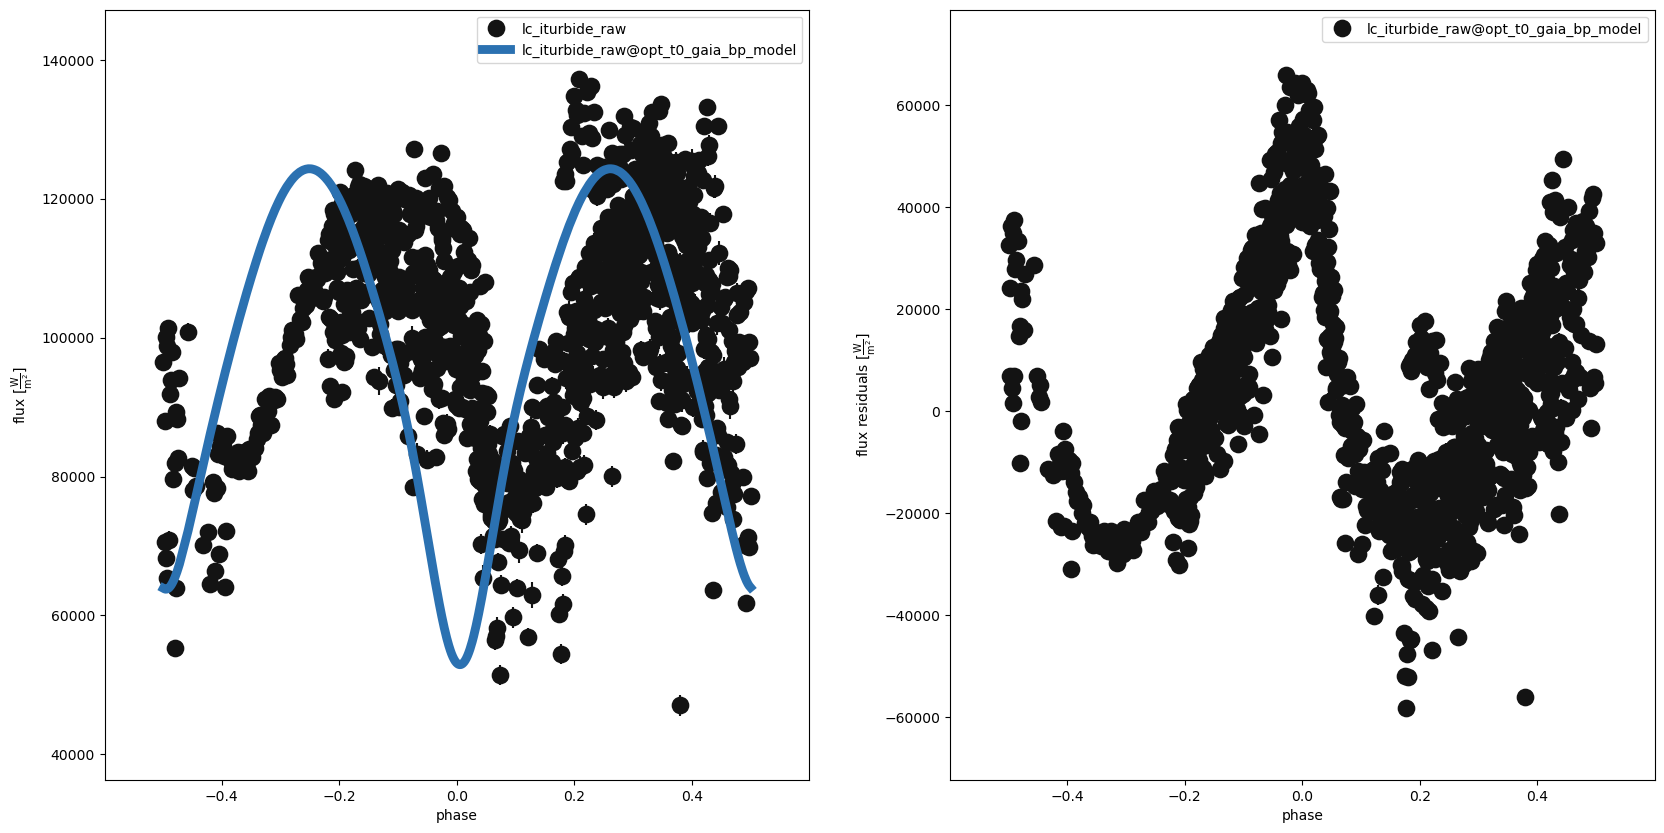

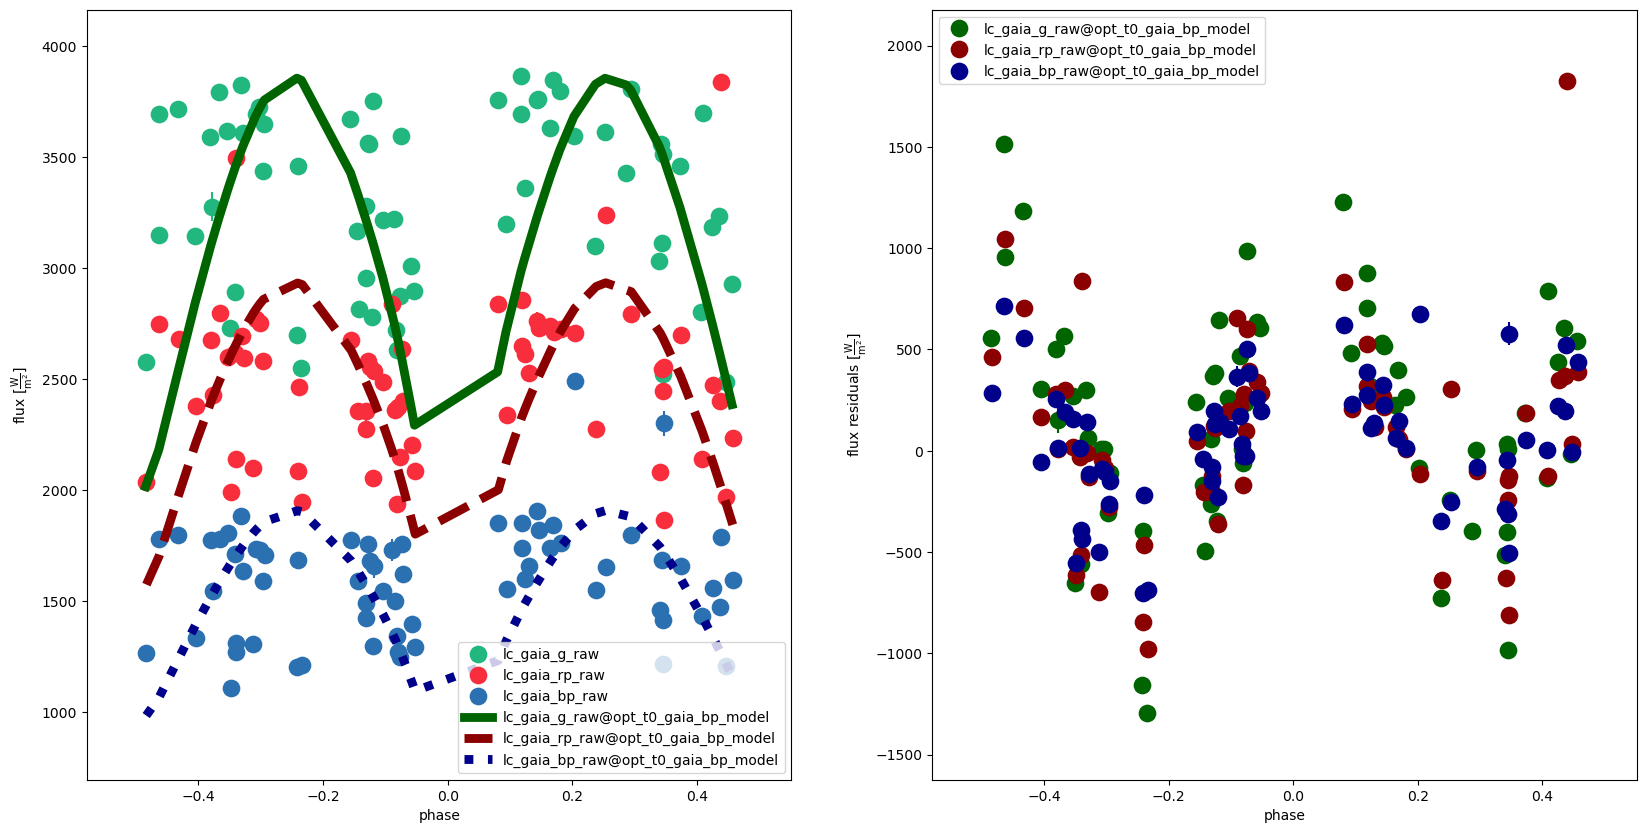

In [20]:
for gd in rawGaiaDatasets:
	label = f't0_{gd.replace("lc_", "").replace("_raw", "")}'
	print(label, "-----------------------------------------------", sep='\n')
	solutionName, computeModelName = opt_utils.adopt_solution(b, label=label, reset_params=True, run_compute=True, plot=False)
	gen_utils.plotModelResidualsFigsize(b, figsize=(20,8), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)
	print()

### Using Iturbide LC only

In [35]:
opt_utils.optimize_params(b, ['t0_supconj'], 't0_iturbide', True, ['lc_iturbide_raw'], maxiter=200)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_t0_iturbide.py ./results/opt_t0_iturbide_solution


('opt_t0_iturbide', 'opt_t0_iturbide_solution')

Adopted:
t0_supconj@binary@orbit@component = 0.13208 d

Original values:
  t0_supconj@binary@orbit@component 0.09631321261339112 d


100%|██████████| 1398/1398 [03:43<00:00,  6.26it/s]


opt_t0_iturbide_solution opt_t0_iturbide_model


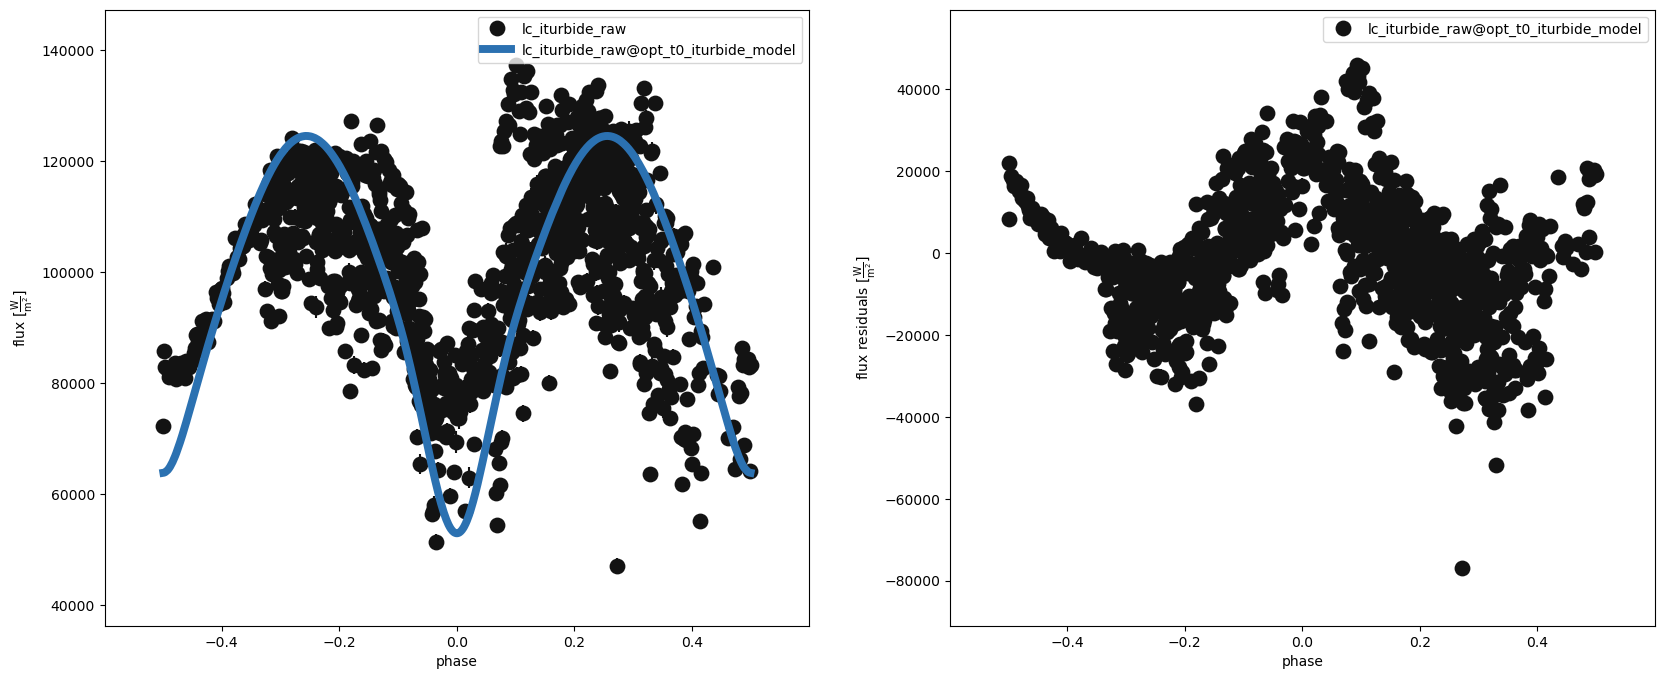

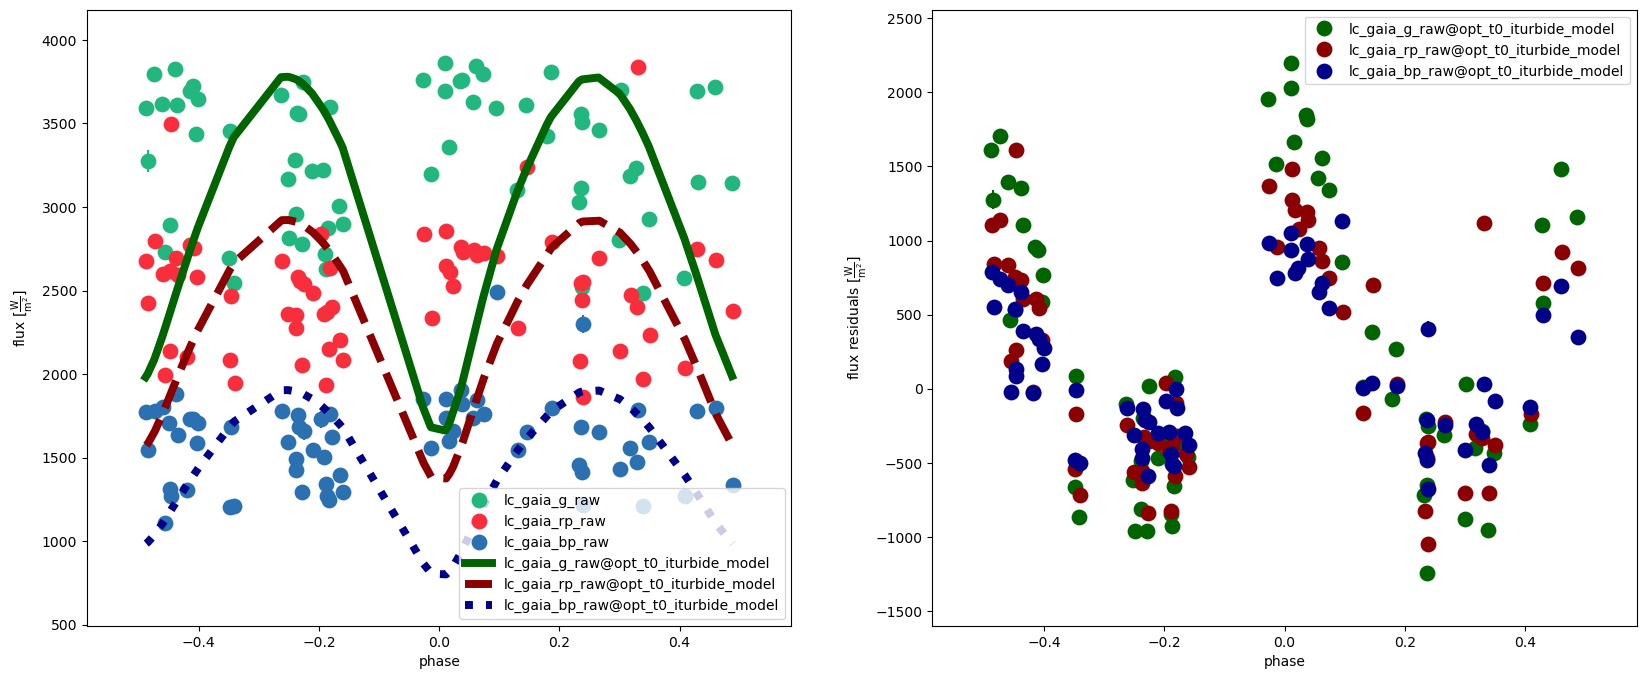

ParameterSet: 11 parameters
R  fitted_twigs@opt_t0_iturbid...: ['t0_supconj@binary@orbit@component']
   adopt_parameters@opt_t0_itu...: ['t0_supconj@binary@orbit@component']
   adopt_distributions@opt_t0_...: False
   adopt_values@opt_t0_iturbid...: True
R  message@opt_t0_iturbide@opt...: Optimization terminated successfully.
R  niter@opt_t0_iturbide@opt_t...: 32
R  success@opt_t0_iturbide@opt...: True
R  initial_values@opt_t0_iturb...: [0.09631321261339112]
R  fitted_values@opt_t0_iturbi...: [0.13207723908706887]
R  fitted_units@opt_t0_iturbid...: ['d']
   comments@opt_t0_iturbide@op...: 
opt_t0_iturbide_model
-------------------------------------
	 Iturbide - 496709.5434402015
	 Gaia - 568058.2354049268
		 lc_gaia_g_raw - 504338.7871925711
		 lc_gaia_rp_raw - 39080.62725851997
		 lc_gaia_bp_raw - 24638.82095383569


In [21]:
solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, 
                                                          solution_file="./external-jobs/results/opt_t0_iturbide_solution", plot=False, 
                                                          dataset=allRawDatasets)
print(solutionName, computeModelName)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

print(b[solutionName])
print("==================================================")
printChi2(b, computeModelName)

### Using `t0_supconj` and `period` determined from Aviles' data

100%|██████████| 1414/1414 [03:36<00:00,  6.54it/s]


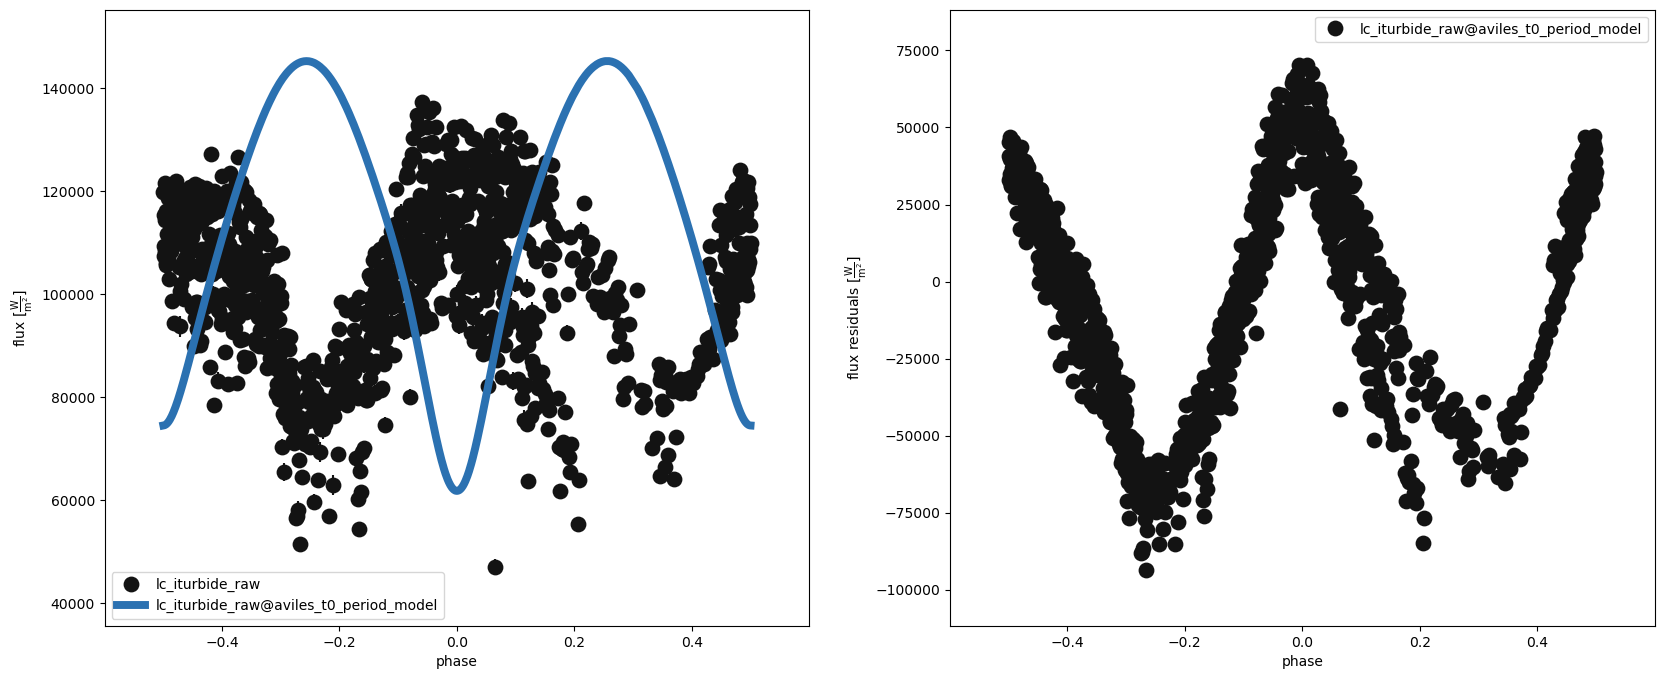

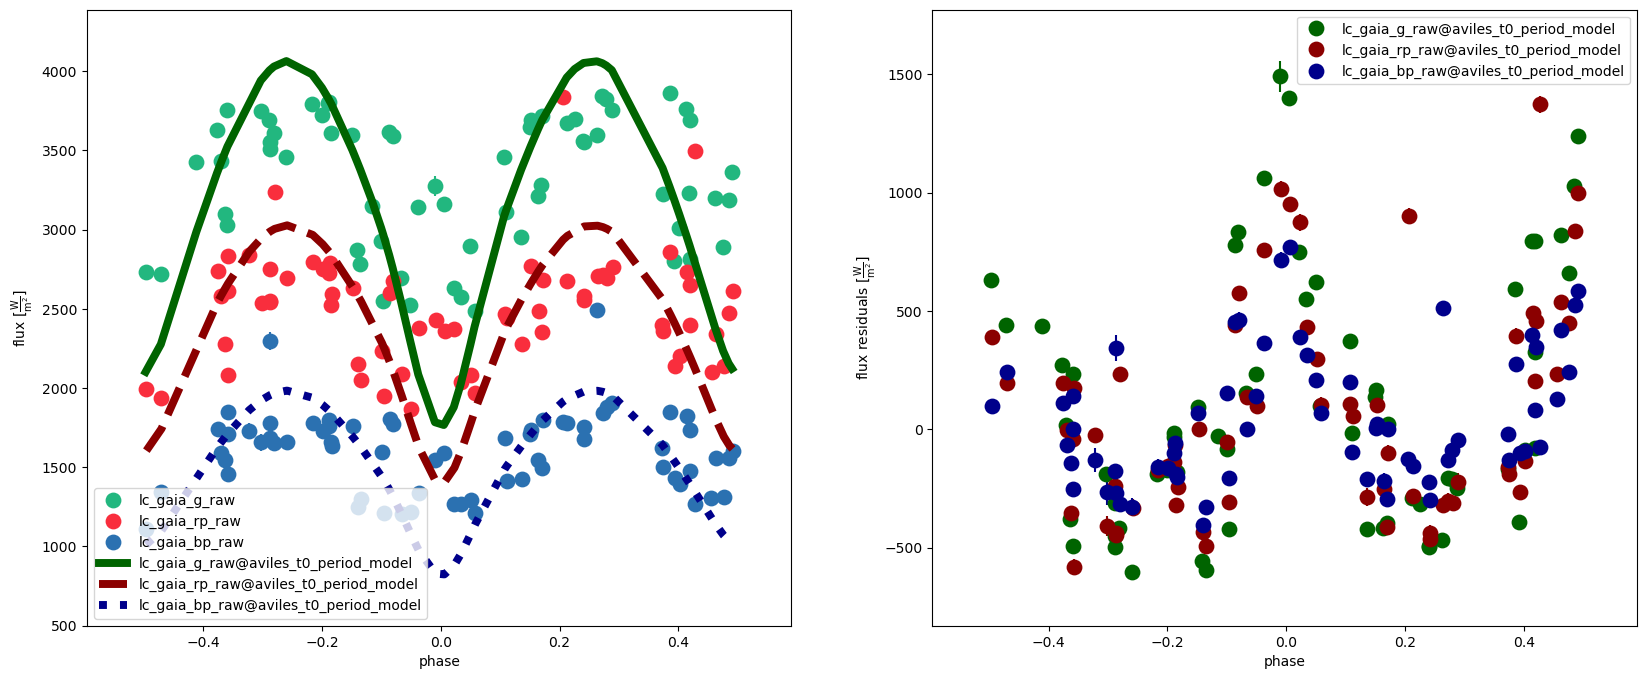

In [22]:
# ParameterSet: 11 parameters
# R  fitted_twigs@opt_period_t0@...: ['t0_supconj@binary@orbit@component' 'period@binary@orbit@component']
#    adopt_parameters@opt_period...: ['t0_supconj@binary@orbit@component', 'period@binary@orbit@component']
#    adopt_distributions@opt_per...: False
#    adopt_values@opt_period_t0@...: True
# R  message@opt_period_t0@opt_p...: Maximum number of iterations has been exceeded.
# R  niter@opt_period_t0@opt_per...: 150
# R  success@opt_period_t0@opt_p...: False
# R  initial_values@opt_period_t...: [0.07183033865425345 0.3335413828053897]
# R  fitted_values@opt_period_t0...: [0.07183187311538936 0.33354138280951534]
# R  fitted_units@opt_period_t0@...: ['d' 'd']
#    comments@opt_period_t0@opt_...: 

b.set_value(qualifier='t0_supconj', component='binary', value=0.07183187311538936*u.day)
b.set_value(qualifier='period', component='binary', value=0.33354138280951534*u.day)

b.run_compute(model='aviles_t0_period_model')
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model='aviles_t0_period_model', legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

## Width and depth of eclipses

`teffratio`, `fillout_factor`
* Testing out `fillout_factor` for parametrization of the shapes of the stars instead of manipulating their equivalent radii

In [9]:
backup = b.copy()

In [44]:
b = backup.copy()

In [46]:
print(b['requiv'])
print(b['requivsumfrac'])
print(b['requivratio'])
print(b['teffratio'])
print(b['mass'])
print(b['sma@binary'])
print(b['pot'])
print(b['fillout_factor'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.0337700401734613 solRad
C      requiv@secondary@component: 1.7436624098728664 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 2 parameters
C  requivsumfrac@binary@component: 0.8290843134466649
         requivsumfrac@constraint: ({requiv@primary@component} + {requiv@secondary@component}) / {sma@binary@component}
ParameterSet: 2 parameters
C    requivratio@binary@component: 1.686702401996762
           requivratio@constraint: {requiv@secondary@component} / {requiv@primary@component}
Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                          

### `lc_gaia_g` only

In [14]:
importlib.reload(opt_utils)
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_gaiag', subfolder="differential-norm-estimates",
						  export=True, datasets=['lc_gaia_g_raw'], maxiter=250)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_teffratio_ff_gaiag.py ./results/opt_teffratio_ff_gaiag_solution


('opt_teffratio_ff_gaiag', 'opt_teffratio_ff_gaiag_solution')

Adopted:
teffratio@binary@orbit@component = 0.93269 
fillout_factor@contact_envelope@envelope@component = 0.04415 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


Wed, 20 Sep 2023 13:55 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [04:13<00:00,  5.58it/s]


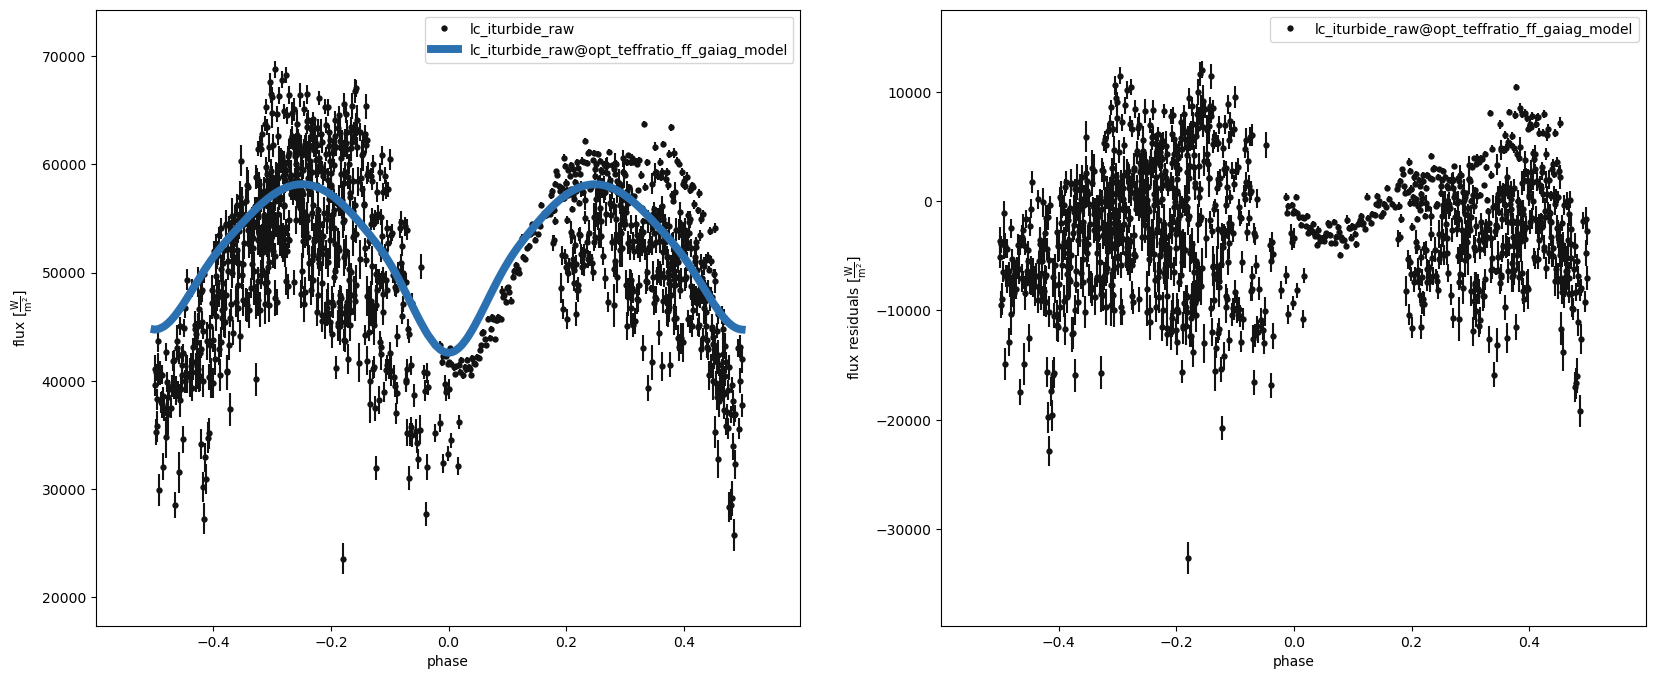

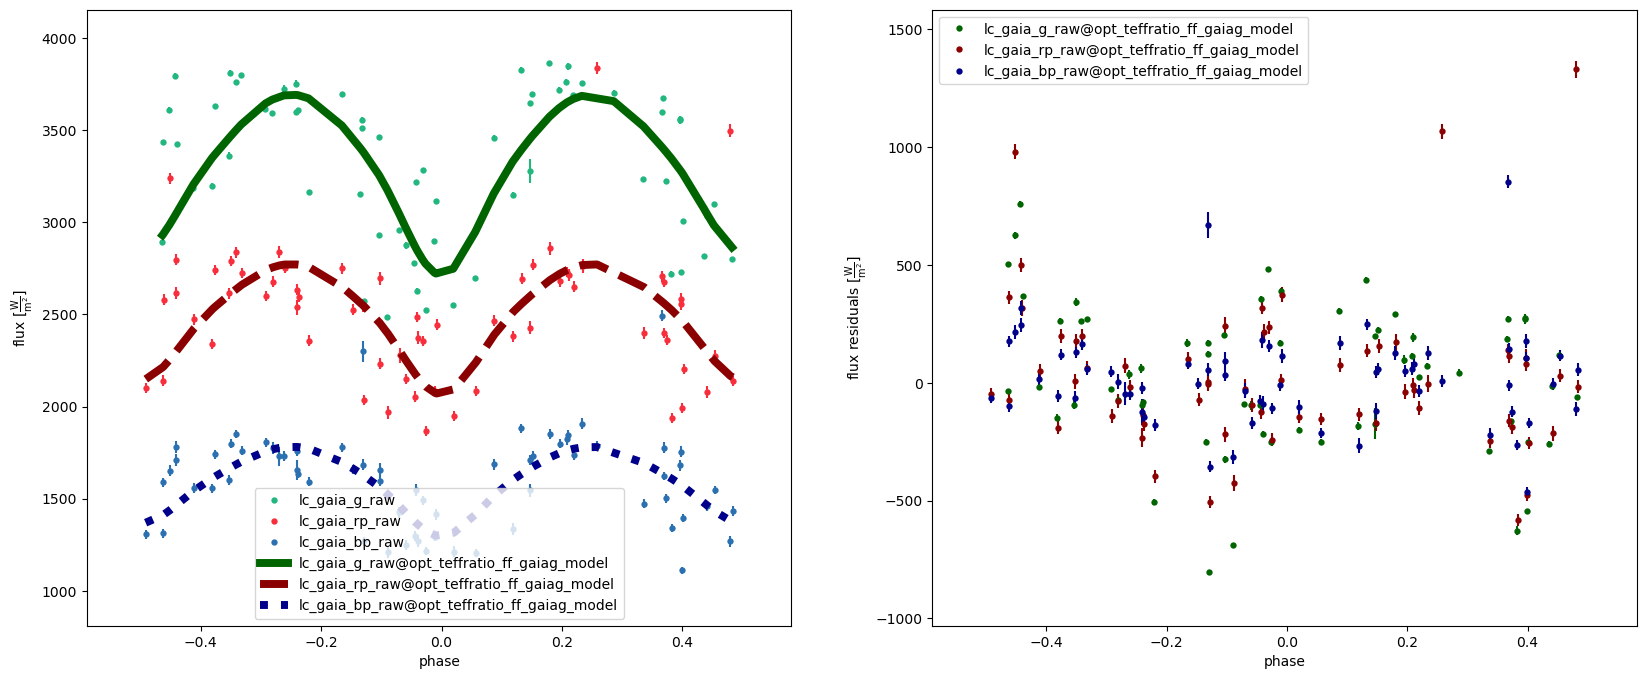

In [11]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_gaiag_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [12]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532


### `lc_iturbide` only

In [16]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_iturbide', subfolder="differential-norm-estimates",
						  export=True, datasets=['lc_iturbide_raw'], maxiter=250)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_teffratio_ff_iturbide.py ./results/opt_teffratio_ff_iturbide_solution


('opt_teffratio_ff_iturbide', 'opt_teffratio_ff_iturbide_solution')

Adopted:
teffratio@binary@orbit@component = 0.85438 
fillout_factor@contact_envelope@envelope@component = 0.29482 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


Wed, 20 Sep 2023 14:00 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:27<00:00,  6.82it/s]


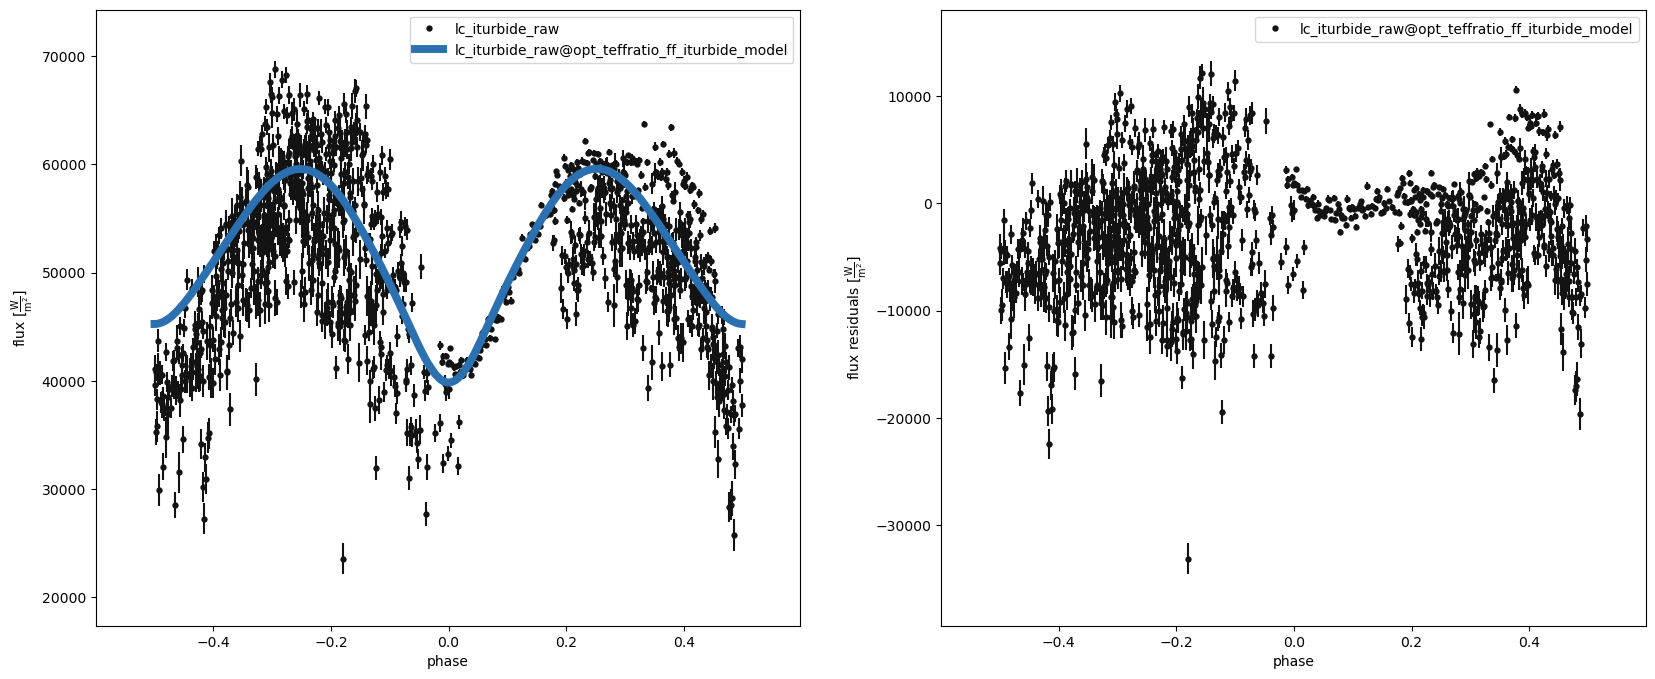

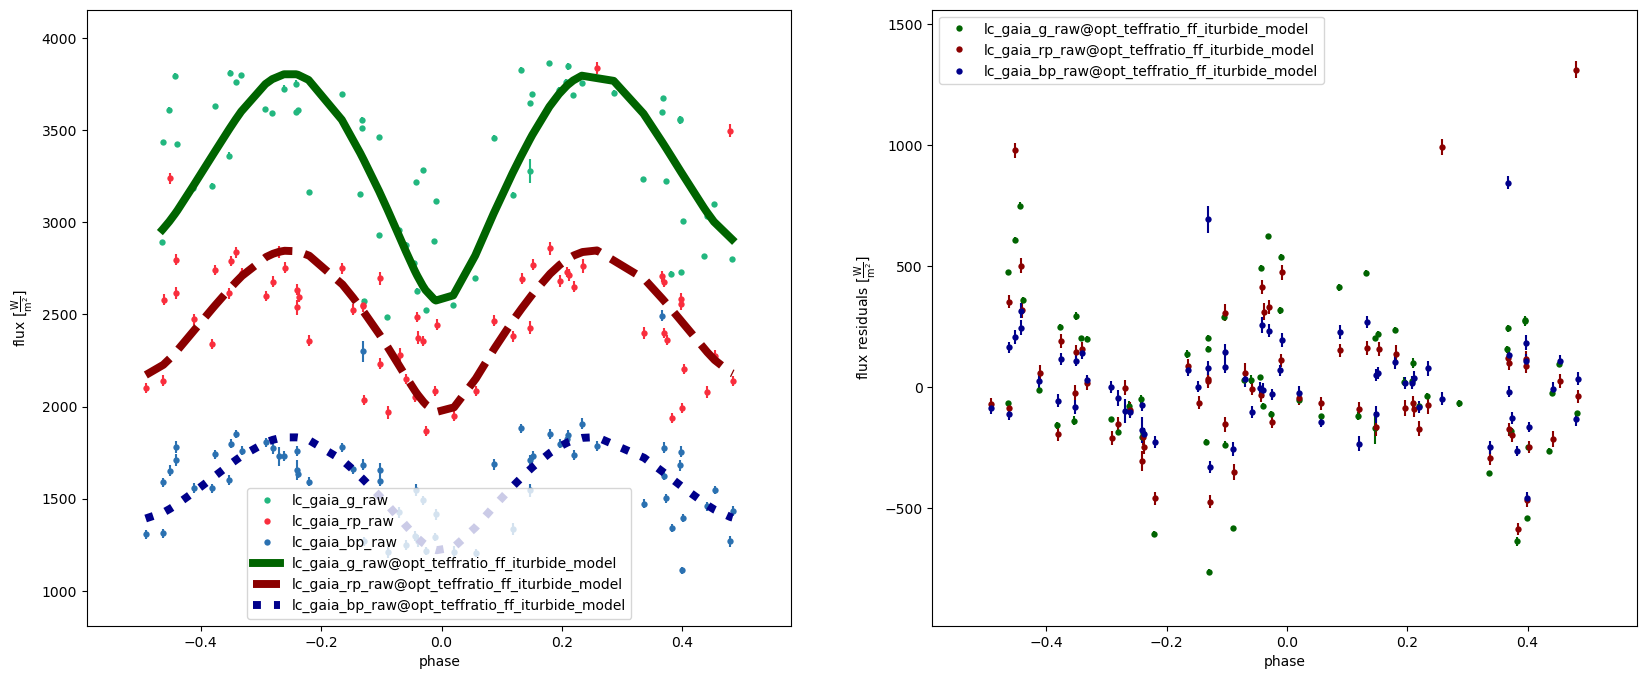

In [13]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_iturbide_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [14]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')
printChi2(b, 'opt_teffratio_ff_iturbide_model')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 52991.952262979496
	 Gaia - 72771.86102981483
		 lc_gaia_g_raw - 62131.844317668496
		 lc_gaia_rp_raw - 7246.9434312625235
		 lc_gaia_bp_raw - 3393.073280883809


### All datasets (Iturbide + Gaia | Raw datasets)

In [17]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_rawdata', subfolder="differential-norm-estimates",
						  export=True, datasets=allRawDatasets, maxiter=250)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_teffratio_ff_rawdata.py ./results/opt_teffratio_ff_rawdata_solution


('opt_teffratio_ff_rawdata', 'opt_teffratio_ff_rawdata_solution')

Adopted:
teffratio@binary@orbit@component = 0.88006 
fillout_factor@contact_envelope@envelope@component = 0.17620 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


Wed, 20 Sep 2023 15:16 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:51<00:00,  6.12it/s]


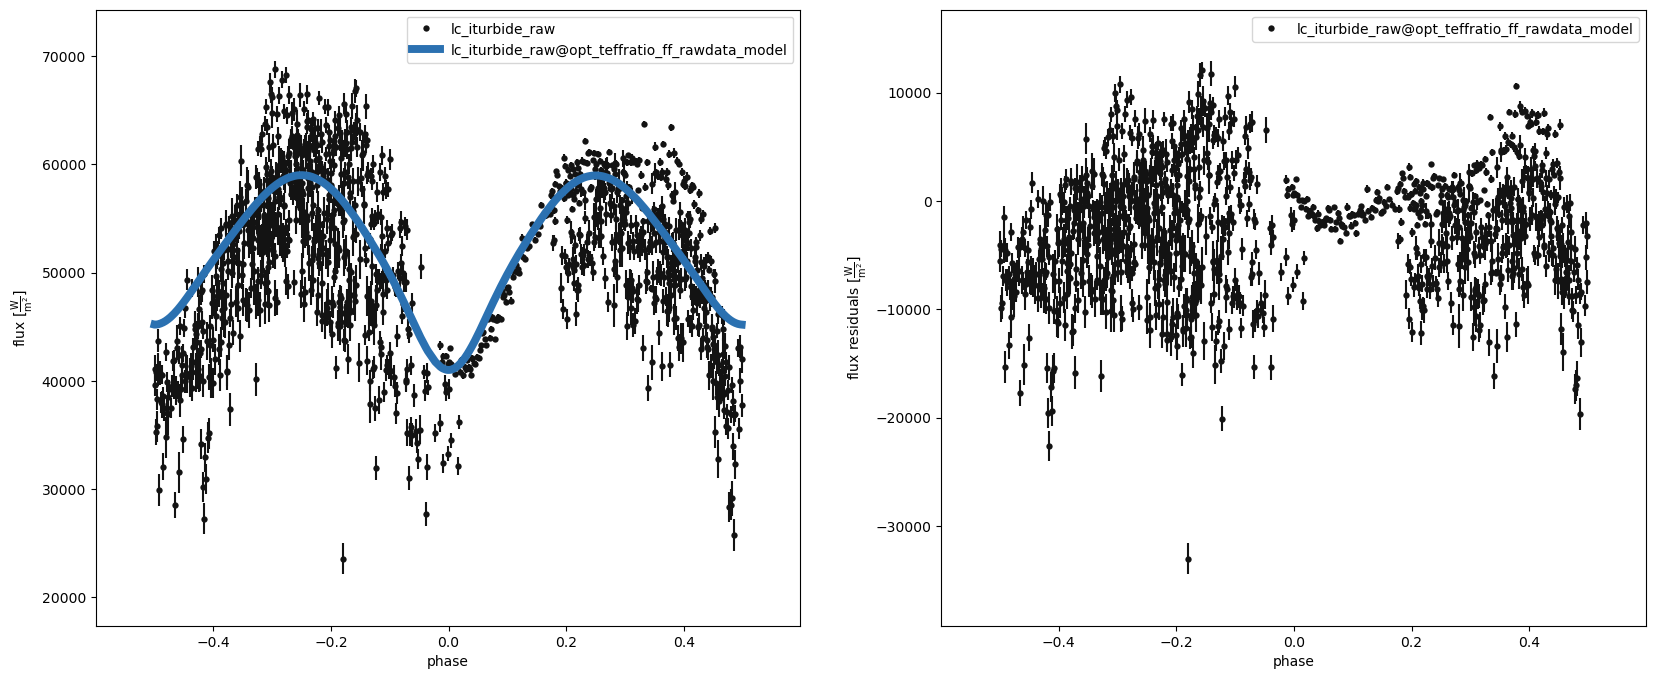

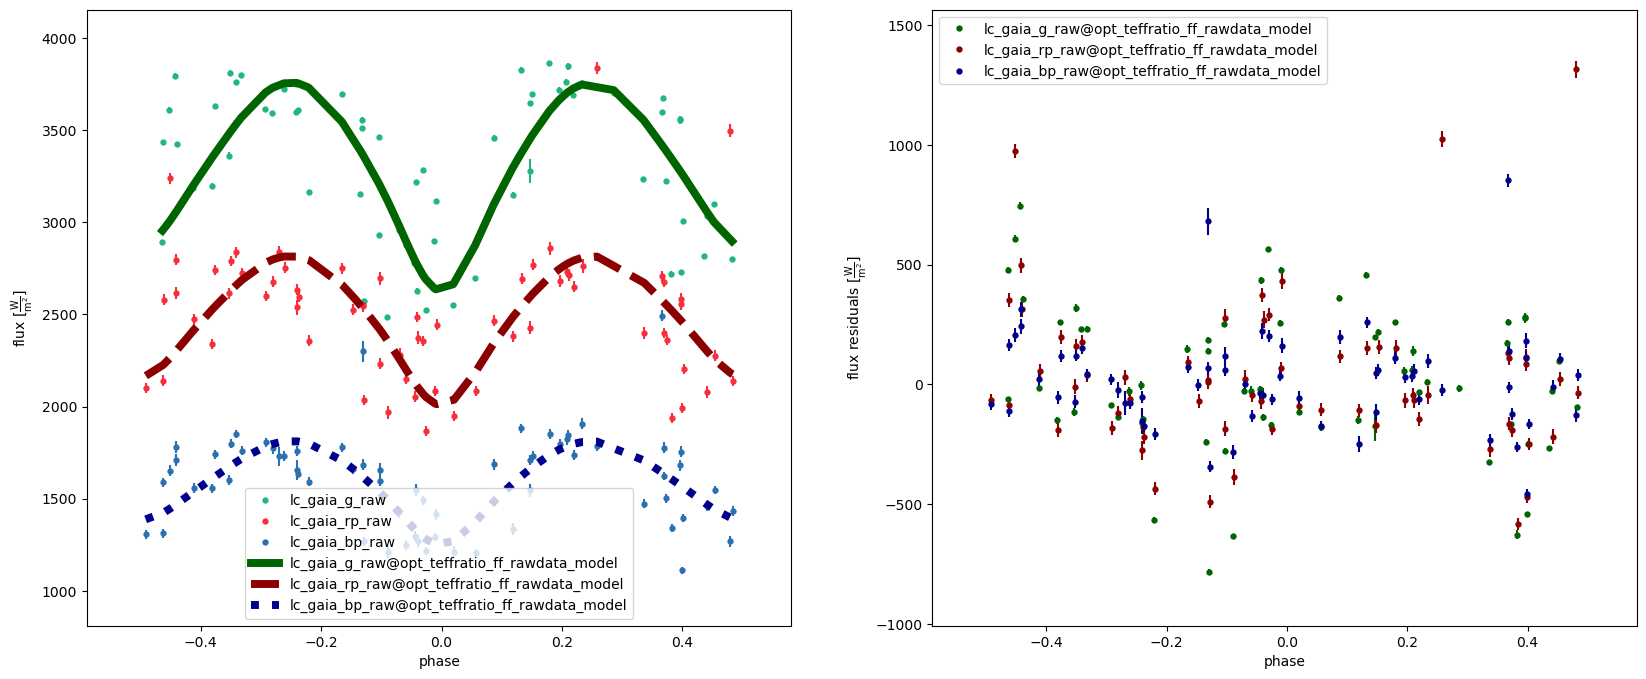

In [16]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_rawdata_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [23]:
for s in [s for s in b.solutions if 'opt_teffratio' in s]:
	print(s, "-----------------------------------", sep='\n')
	gen_utils.printFittedVals(b, s)
	print()

opt_teffratio_ff_gaiag_solution
-----------------------------------
teffratio@binary@orbit@component = 0.93269 
fillout_factor@contact_envelope@envelope@component = 0.04415 

opt_teffratio_ff_iturbide_solution
-----------------------------------
teffratio@binary@orbit@component = 0.85438 
fillout_factor@contact_envelope@envelope@component = 0.29482 

opt_teffratio_ff_rawdata_solution
-----------------------------------
teffratio@binary@orbit@component = 0.88006 
fillout_factor@contact_envelope@envelope@component = 0.17620 



In [24]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')
printChi2(b, 'opt_teffratio_ff_iturbide_model')
printChi2(b, 'opt_teffratio_ff_rawdata_model')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 52991.952262979496
	 Gaia - 72771.86102981483
		 lc_gaia_g_raw - 62131.844317668496
		 lc_gaia_rp_raw - 7246.9434312625235
		 lc_gaia_bp_raw - 3393.073280883809
opt_teffratio_ff_rawdata_model
----------------------------

In [25]:
gen_utils.saveBundle(b, "dataset-scaled-optimized", "full-diff-data")

'bundle-saves/full-diff-data/dataset-scaled-optimized'

## Adjusting the passband luminosity

Will be trying to adjust the passband luminosity for both the Iturbide light curve as well as the Gaia G light curve. To preserve the colors,
Gaia BP and RP will be set to scale to Gaia G (if possible).